### Data analysis of Section 11 data.

1. Check all surface maps without thermal compensation
1. Check all surface maps with thermal compensation (due to poor thermal condition, we had to use these for optimization)
1. Make T maps for each surface
2. Plot the RB corrections as a function of iteration.
2. Plot bending force RMS as a function of iteration.
2. Spot check the forces applied at each iteration were applied as intended (Gravity+optimized+bending)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.jet()

import sys
sys.path.insert(0, '../')
from M1S_tools import *
import glob
import shutil

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_165SA_09Jan2025/
Afz =  (27547, 165)
U matrix (27547, 165)
S matrix (165, 165)

<Figure size 640x480 with 0 Axes>

In [2]:
_, filesetM = parse_ml_data_folder('%s/Sec 11/27 modes/250211/'%(ml_data_dir))

x 250211_3/250211 GMT3 set3 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched - 27 GMT modes.h5
x 250211_3/250211 GMT3 set3 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5
x 250211_4/250211 GMT3 set4 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched - 27 GMT modes.h5
x 250211_4/250211 GMT3 set4 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5
x 250211_5/250211 GMT3 set5 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5
x 250211_5/250211 GMT3 set5 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched - 27 GMT modes.h5
x 250211_2/250211 GMT3 set2 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched - 27 GMT modes.h5
x 250211_2/250211 GMT3 set2 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5
x 250211_12/250211 GMT3 set12 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5
x 250211_12/250211 GMT3 set12 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched

In [22]:
dateID = '250211'
niter = 13
ntsamples = 100
iter_offset = 0
nBMs = 27
band_width = 6 #in minutes; how long it took for each measurement
iterStr = ['%s'%(i+1) for i in range(niter)]
iterStr[6] = '6_b'
for i in range(7, niter):
    iterStr[i] = '%s'%i
print(iterStr)
iterStr1 = iterStr.copy()
iterStr1[6] = '6 b'
print(iterStr1)

['1', '2', '3', '4', '5', '6', '6_b', '7', '8', '9', '10', '11', '12']
['1', '2', '3', '4', '5', '6', '6 b', '7', '8', '9', '10', '11', '12']


/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_1/250211 GMT3 set1 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5: date not in h5 file. 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_2/250211 GMT3 set2 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5: date not in h5 file. 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_3/250211 GMT3 set3 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5: date not in h5 file. 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_4/250211 GMT3 set4 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5: date not in h5 file. 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_5/250211 GMT3 set5 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched.h5: date not in h5 file. 


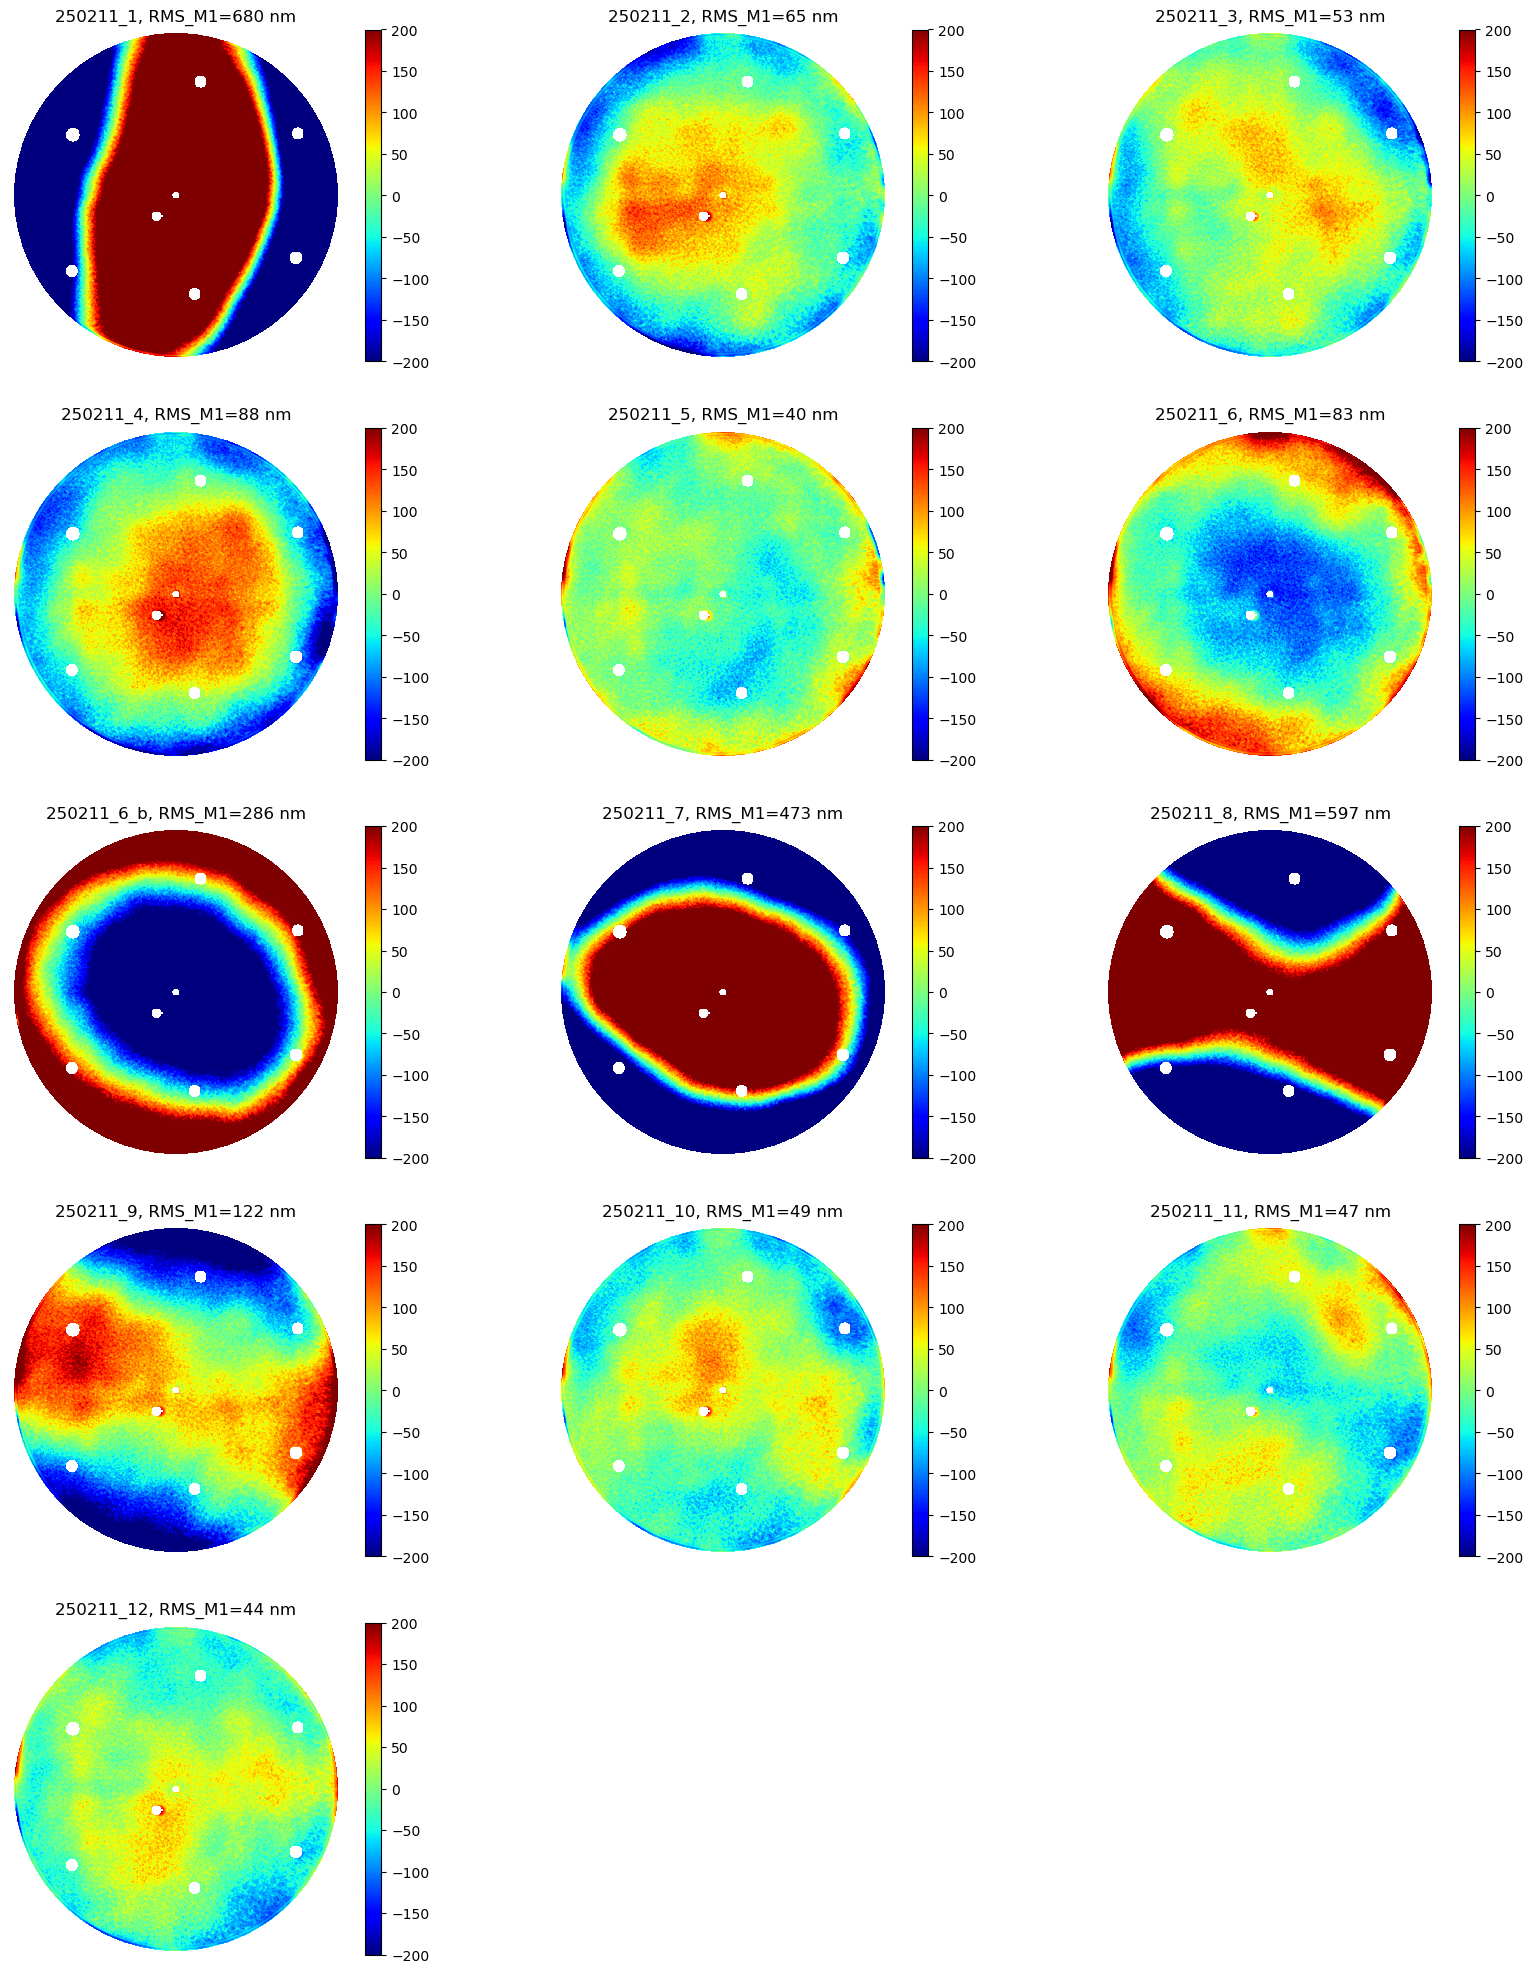

In [12]:
#plot processed maps from each iteration
m1s_array = np.zeros((Sxn, Syn, niter))
m1rms_array = np.zeros(niter)
nrow = 5
fig, ax = plt.subplots(nrow,3,figsize=(20,nrow*5))
for i in range(niter):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    
    fileset = sorted(glob.glob('%s/Sec 11/27 modes/%s/%s_%s/%s*set*patched.h5'%(
        ml_data_dir,dateID, dateID, iterStr[i], dateID)))

    assert len(fileset)==1 #for optimization, Buddy decided to do ONE measurements per iteration
    m1s,centerRow,centerCol,pixelSize,ts = readH5Map(fileset)
    m1s *= 1000 #convert into nm
    m1s_array[:,:, i] = m1s
    
    m1rms_array[i] = np.std(m1s[~np.isnan(m1s)])
    img = ax[irow][icol].imshow(m1s, origin='lower', vmin=-200, vmax=200)
    fig.colorbar(img, ax=ax[irow][icol])
    ax[irow][icol].set_title('%s_%s, RMS_M1=%.0f nm'%(dateID,iterStr[i], m1rms_array[i]))
    ax[irow][icol].axis('off')
    if m1rms_array[i]<=40:
        shutil.copy2(fileset[0], '../opti_h5/')
for i in range(3*nrow):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    ax[irow][icol].axis('off')    

In [13]:
#we have to retrieve timestamps from earlier stage data files
#below is only for retrieving timestamps
ts_array = []
for i in range(niter):
    globstring = '%s/Sec 11/27 modes/%s/%s_%s/%s*set*comp -.h5'%(ml_data_dir, dateID, dateID, iterStr[i], dateID)
    fileset = sorted(glob.glob(globstring))
    assert len(fileset)==1 #for optimization, Buddy decided to do ONE measurements per iteration
    temp,centerRow,centerCol,pixelSize,ts = readH5Map(fileset)
    ts_array.append(ts)

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_1/250211 GMT3 set1 11.2 10 27 modes gmtMorph170614 LFSsub comp -.h5: Tue Feb 11 11:36:58 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_2/250211 GMT3 set2 11.2 10 27 modes gmtMorph170614 LFSsub comp -.h5: Tue Feb 11 11:58:31 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_3/250211 GMT3 set3 11.2 10 27 modes gmtMorph170614 LFSsub comp -.h5: Tue Feb 11 12:13:51 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_4/250211 GMT3 set4 11.2 10 27 modes gmtMorph170614 LFSsub comp -.h5: Tue Feb 11 12:25:44 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_5/250211 GMT3 set5 11.2 10 27 modes gmtMorph170614 LFSsub comp -.h5: Tue Feb 11 12:40:08 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_1/250211 GMT3 set1 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched - 27 GMT modes.h5: date not in h5 file. 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_2/250211 GMT3 set2 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched - 27 GMT modes.h5: date not in h5 file. 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_3/250211 GMT3 set3 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched - 27 GMT modes.h5: date not in h5 file. 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_4/250211 GMT3 set4 11.2 10 27 modes gmtMorph170614 LFSsub comp - stitched patched - 27 GMT modes.h5: date not in h5 file. 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 11/27 modes/250211/250211_5/250211 GMT3 set5 11.2 10 27 modes gmtMorph1706

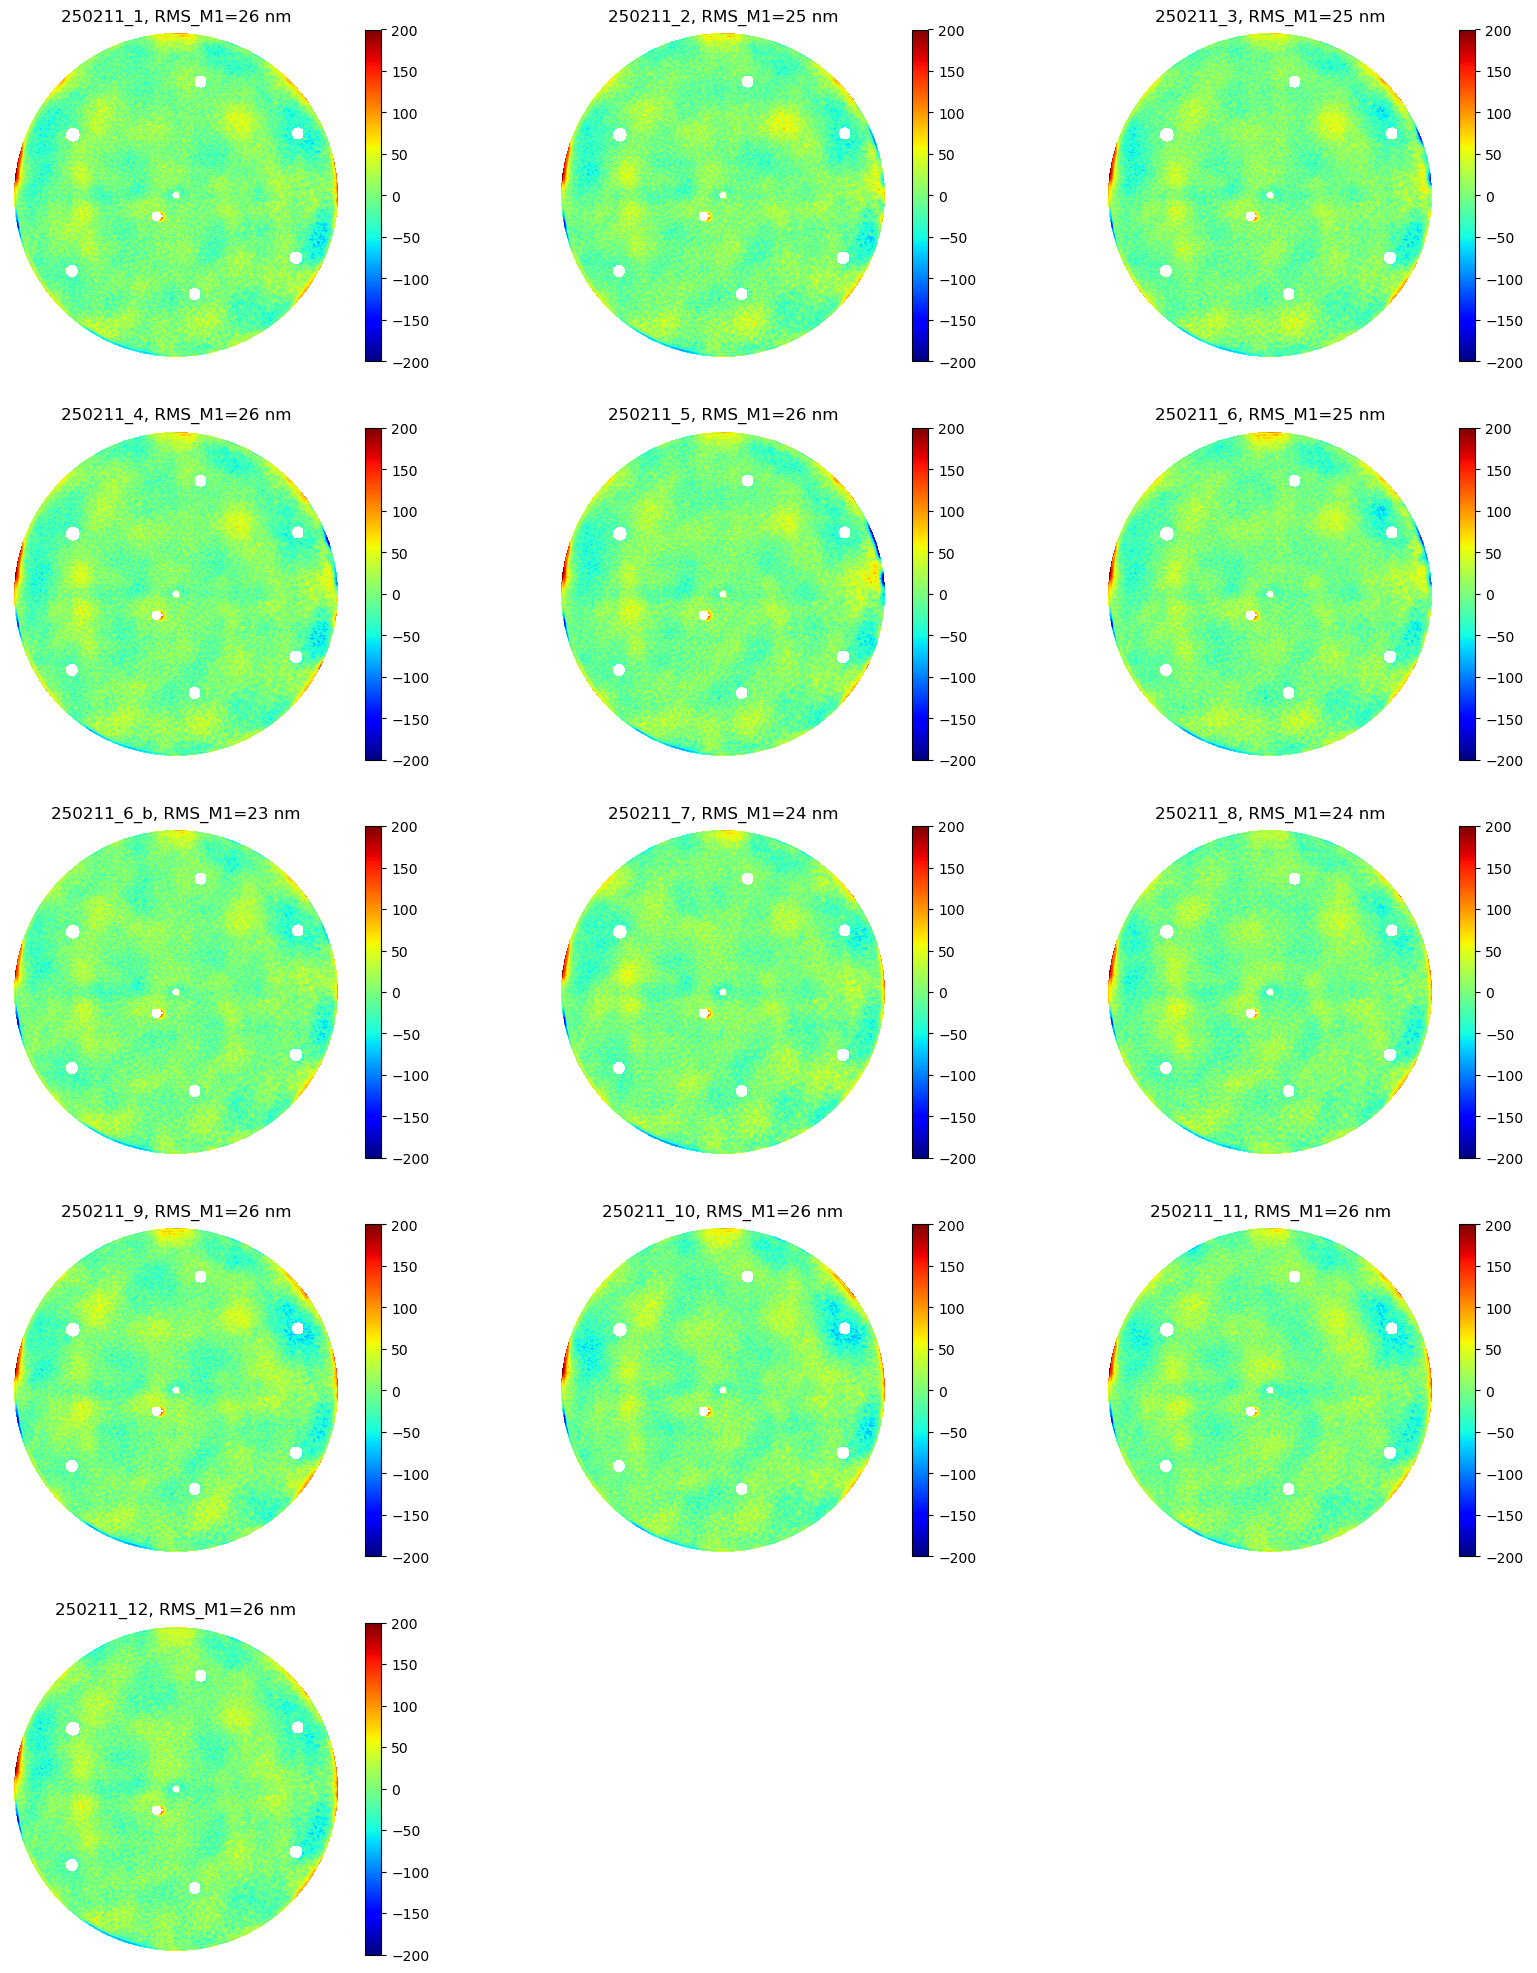

In [16]:
#predicted maps at each iteration
m1s_array_predict = np.zeros((Sxn, Syn, niter))
fig, ax = plt.subplots(nrow,3,figsize=(20,nrow*5))
for i in range(niter):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    
    fileset = sorted(glob.glob('%s/Sec 11/27 modes/%s/%s_%s/%s*set*patched - 27 GMT modes.h5'%(
        ml_data_dir, dateID, dateID, iterStr[i], dateID)))

    assert len(fileset)==1 #for optimization, Buddy decided to do ONE measurements per iteration
    m1s,centerRow,centerCol,pixelSize,ts = readH5Map(fileset)
    m1s *= 1000 #convert into nm
    m1s_array_predict[:,:, i] = m1s
    
    m1rms = np.std(m1s[~np.isnan(m1s)])
    img = ax[irow][icol].imshow(m1s, origin='lower', vmin=-200, vmax=200)
    fig.colorbar(img, ax=ax[irow][icol])
    ax[irow][icol].set_title('%s_%s, RMS_M1=%.0f nm'%(dateID,iterStr[i], m1rms))
    ax[irow][icol].axis('off')
for i in range(nrow*3):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    ax[irow][icol].axis('off')    

on bar 135
on bar 235
on bar 335
on bar 435
on puck  1135
on puck  1235
on puck  1335
on puck  1435


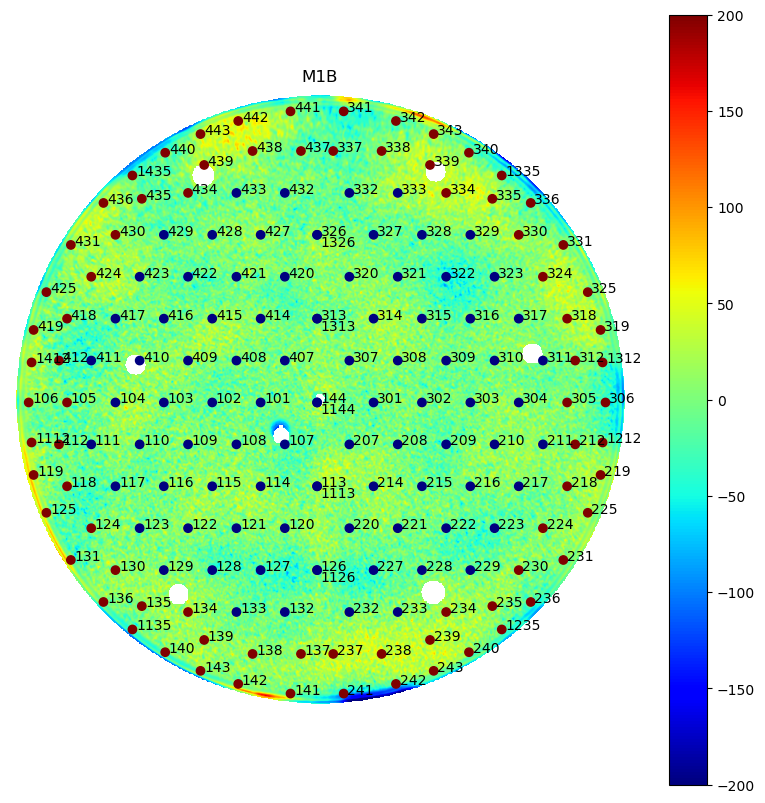

In [24]:
m1s = np.mean(m1s_array_predict, axis=2)
m1s = -m1s.T

fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(m1s, origin='lower', vmin=-200, vmax=200)
plt.title('M1B')
plt.axis('off')
plt.colorbar()
saxpix = np.zeros_like(sax)
saypix = np.zeros_like(say)
sa8 = []
for i in range(len(sax)):
    saxpix[i] = saID2pixx(saID[i], centerRow, centerCol, pixelSize)
    saypix[i] = saID2pixy(saID[i], centerRow, centerCol, pixelSize)
    if (np.any(abs(sax[i]+say[i]-sax[:i]-say[:i])<1e-4)):
        plt.text(saxpix[i]+.05/pixelSize, saypix[i]-0.15/pixelSize, str(saID[i]))
    else:
        plt.text(saxpix[i]+.05/pixelSize, saypix[i], str(saID[i]))
    if np.mod(saID[i],100) == 35:
        sa8.append(saID[i])
        if dfSA['LSActType'][i]==30:
            print('on puck ', saID[i])
        if dfSA['LSActType'][i]==31:
            print('on bar', saID[i])
plt.scatter(saxpix, saypix, c=saz);

In [26]:
from scipy.io import savemat
[x1, y1] = mkXYGrid(m1s, centerRow, centerCol, pixelSize)
data = {'m1s': m1s, 'x1': x1, 'y1':y1}
savemat('m1surf_250211.mat', data)

../GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
on bar 135
on bar 235
on bar 335
on bar 435
on puck  1135
on puck  1235
on puck  1335
on puck  1435


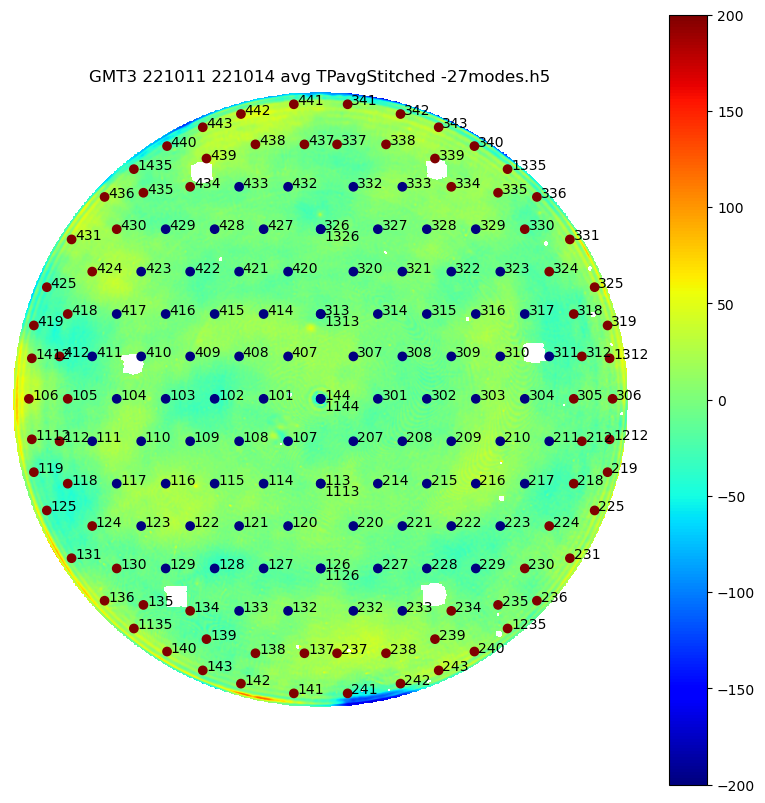

In [23]:
filename = '../GMT3 221011 221014 avg TPavgStitched -27modes.h5'
m1s,centerRow,centerCol,pixelSize,ts = readH5Map([filename])
m1s = -m1s.T * 1000

fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(m1s, origin='lower', vmin=-200, vmax=200)
plt.title(filename[3:])
plt.axis('off')
plt.colorbar()
saxpix = np.zeros_like(sax)
saypix = np.zeros_like(say)
sa8 = []
for i in range(len(sax)):
    saxpix[i] = saID2pixx(saID[i], centerRow, centerCol, pixelSize)
    saypix[i] = saID2pixy(saID[i], centerRow, centerCol, pixelSize)
    if (np.any(abs(sax[i]+say[i]-sax[:i]-say[:i])<1e-4)):
        plt.text(saxpix[i]+.05/pixelSize, saypix[i]-0.15/pixelSize, str(saID[i]))
    else:
        plt.text(saxpix[i]+.05/pixelSize, saypix[i], str(saID[i]))
    if np.mod(saID[i],100) == 35:
        sa8.append(saID[i])
        if dfSA['LSActType'][i]==30:
            print('on puck ', saID[i])
        if dfSA['LSActType'][i]==31:
            print('on bar', saID[i])
plt.scatter(saxpix, saypix, c=saz);

In [17]:
# fit surface map from each iteration to Zernike
#nzer = int(#(6*7)/2+1)
nzer = int((8*9)/2+1) 
zercoeff = np.zeros((niter, nzer))

[x1, y1] = mkXYGrid(m1s, centerRow, centerCol, pixelSize)
r1 = np.sqrt(x1**2 + y1**2)

nnodes = x1.shape[0]*x1.shape[1]
zerU = np.zeros((nnodes, nzer))
for izer in range(nzer):
    zerU[:,izer] = zernike_polynomial(izer+1, x1/radius_of_CA, y1/radius_of_CA).flatten()
for i in range(niter):
    m1s = np.squeeze(m1s_array[:,:,i])
    maskNew = (~np.isnan(m1s) ) & (r1<radius_of_CA)
    nnodesNew = np.sum(maskNew)
    zercoeff[i,:] = zerU[maskNew.flatten(),:].transpose() / nnodesNew @ m1s[maskNew]


In [18]:
## define continuous timestamps
start_time = unix_ts(ts_array[0])-60*6 - 60 #1 minute before starting the first measurement
end_time = unix_ts(ts_array[-1])+60*5 #5 minute after the last measurement
#get continuous mirror positions
mirror_pos_ntsamples, tt = getDBData(start_time,'m1_s1_support_ctrl/s/mirror_position/value', 
                                   duration_in_s=end_time-start_time, samples=ntsamples)
#get continuous bending forces
bend_force_ntsamples, tt = getDBData(start_time,'m1_s1_support_ctrl/s/sa_bending_force/value', 
                           duration_in_s=end_time-start_time, samples=ntsamples)
bend_force_z_ntsamples = bend_force_ntsamples[:,:,2]
# convert continuous forces to continuous BM coeffs.
bm_coeff_ntsamples = np.zeros((ntsamples, nBMs))
for i in range(ntsamples):
    bm_coeff_ntsamples[i,:] = VMat[:, :nBMs].transpose() @ gmt170Fvec2gmt165Fvec(bend_force_z_ntsamples[i,:]) \
        / np.sum(VMat[:,:nBMs]**2, axis=0)

m1_s1_support_ctrl/s/mirror_position/value
2025-02-11 11:29:58  duration =  16086  s
(100, 6)
m1_s1_support_ctrl/s/sa_bending_force/value
2025-02-11 11:29:58  duration =  16086  s
(100, 170, 3)


In [19]:
# get TC data
tc, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/tc_temperature/value', 
                   duration_in_s=end_time-start_time, samples=ntsamples)
tambient, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/ambient_temperature/value', 
                         duration_in_s=end_time-start_time, samples=ntsamples)
idxfo = np.sqrt(tc_locs[idx_mirror_f,0]**2+tc_locs[idx_mirror_f,1]**2) > 4
idxfi = np.sqrt(tc_locs[idx_mirror_f,0]**2+tc_locs[idx_mirror_f,1]**2) < 1
idxbo = np.sqrt(tc_locs[idx_mirror_b,0]**2+tc_locs[idx_mirror_b,1]**2) > 4
idxbi = np.sqrt(tc_locs[idx_mirror_b,0]**2+tc_locs[idx_mirror_b,1]**2) < 1

m1_s1_thermal_ctrl/i/tc_temperature/value
2025-02-11 11:29:58  duration =  16086  s
(100, 192)
m1_s1_thermal_ctrl/i/ambient_temperature/value
2025-02-11 11:29:58  duration =  16086  s
(100,)


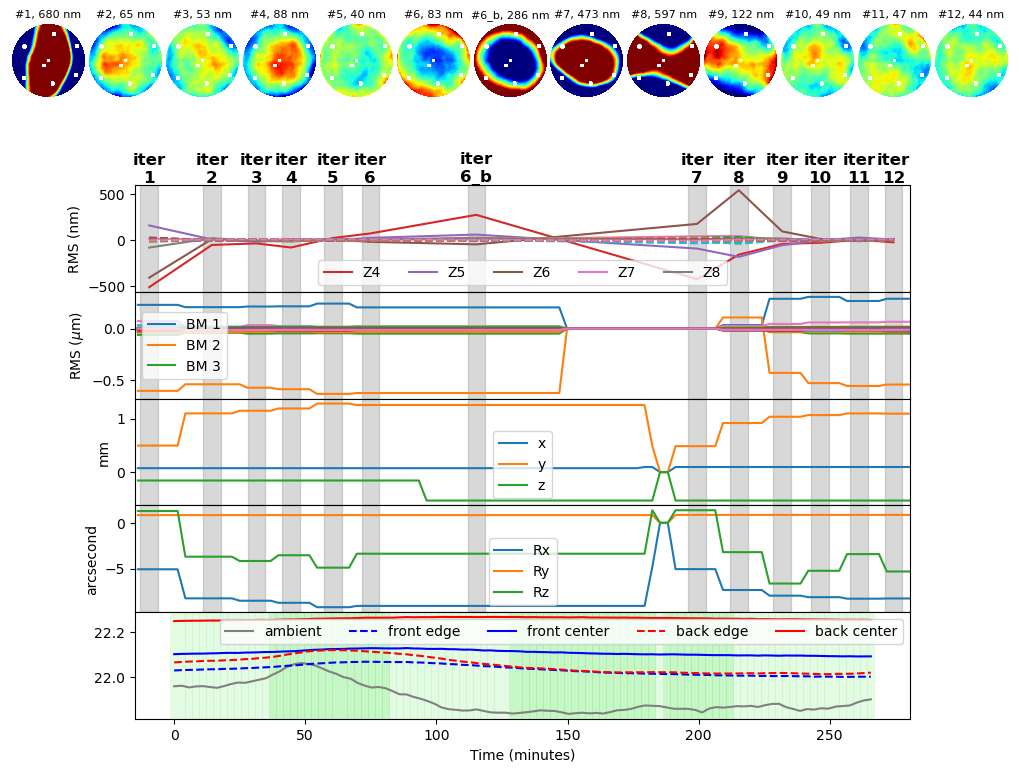

In [29]:
plotOptimization(m1s_array, m1rms_array, ts_array, zercoeff, ntsamples, bm_coeff_ntsamples, tt, 
                 mirror_pos_ntsamples, tambient, tc, band_width, iter_offset, iterStr=iterStr)